## Подготовка данных

Импортируем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import lightgbm as lgb

warnings.filterwarnings('ignore')
from catboost import CatBoostRegressor
from pandas.api.types import CategoricalDtype
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor 
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

Загрузим данные

In [2]:
data = pd.read_csv('/datasets/autos.csv')
display(data.head(5))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Описание столбцов есть в условиях задачи:

**Признаки:**

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

**Целевой признак:**

Price — цена (евро)

Посмотрим инфо:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В датафрейме точно есть пропуски. Однако, первым делом, попробуем разобраться, нет ли в нем лишних столбцов.

1) DateCrawled — дата скачивания анкеты из базы - такие данные точно не повлияют на цену автомобиля.

2) LastSeen — дата последней активности пользователя - аналогично

3) RegistrationMonth - также на цену никак повлиять не должен.

4) PostalCode — почтовый индекс владельца анкеты (пользователя)- аналогично

Удалим эти столбцы.

In [4]:
data = data.drop(['DateCrawled','LastSeen', 'RegistrationMonth', 'PostalCode'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
 10  DateCreated       354369 non-null  object
 11  NumberOfPictures  354369 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 32.4+ MB


Посмотрим на оставшиеся данные:

In [5]:
display(data.head(10))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,NumberOfPictures
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24 00:00:00,0
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24 00:00:00,0
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14 00:00:00,0
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00,0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00,0
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,2016-04-04 00:00:00,0
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,2016-04-01 00:00:00,0
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,2016-03-21 00:00:00,0
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN,2016-04-04 00:00:00,0
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN,2016-03-17 00:00:00,0


Видим одни нули в столбце NumberOfPictures. Проверим, есть ли в этом столбце другие значения.

In [6]:
display(data['NumberOfPictures'].unique())

array([0])

В столбце одни нули. Возможно, эти данные в принципе не были занесены в исходный файл. Так или иначе, в таком виде столбец бесполезен, удалим и его.

In [7]:
data = data.drop(['NumberOfPictures'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
 10  DateCreated       354369 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


Итак, у нас осталось 10 столбцов, и в них по-прежнему есть пропуски. Посчитаем, сколько есть пропусков, и в каких столбцах. Названия столбцов, в которых есть пропуски, соберем в переменную col_w_nan

In [8]:
col_w_nan = []
for col in data.columns:
    col_space = data[col].isna().sum()
    if col_space > 0:
        col_w_nan.append(col)
        print('В столбце', col, col_space, 'пропусков, что составляет', col_space/data.shape[0]*100,'процентов')

В столбце VehicleType 37490 пропусков, что составляет 10.57936783409384 процентов
В столбце Gearbox 19833 пропусков, что составляет 5.596708515699737 процентов
В столбце Model 19705 пропусков, что составляет 5.560587974681758 процентов
В столбце FuelType 32895 пропусков, что составляет 9.282696849893755 процентов
В столбце Repaired 71154 пропусков, что составляет 20.079070121822166 процентов


Как видим, в этих столбцах пропусков очень много, особенно- в столбце Repaired- каждое пятое значение пропущено. Изучим значения в каждом из этих столбцов, и подумаем, что с этим можно сделать.

Для начала, проверим, сколько в каждом из этих столбцов есть уникальных значений.

In [9]:
for col in col_w_nan:
    display(data[col].unique())

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

array(['manual', 'auto', nan], dtype=object)

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

array([nan, 'yes', 'no'], dtype=object)

Построим круговые диаграммы для каждого из этих столбцов, кроме моделей, и посмотрим распределение значений в них.
Для моделей стоить диаграмму не будем, т.к. в этом столбце слишком много уникальных значений.

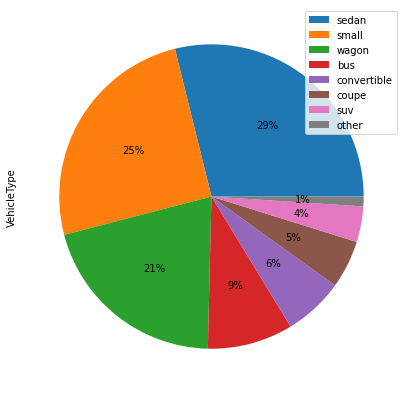

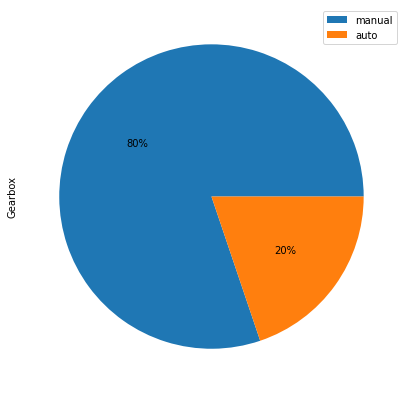

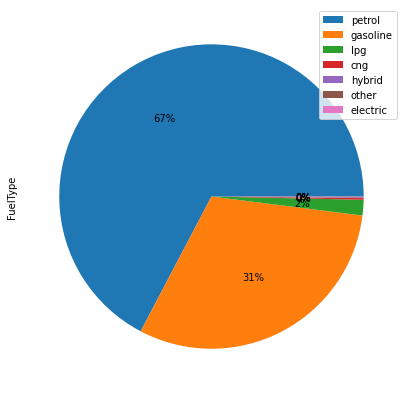

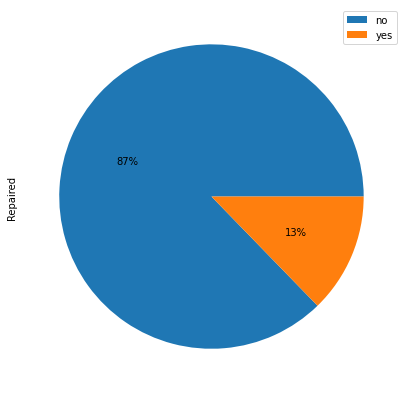

In [10]:
col_w_nan = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
for col in col_w_nan:
    plt.figure(figsize=(7, 7))
    data[col].value_counts().plot(kind='pie', autopct='%1.0f%%', labeldistance=None, legend=True)
    plt.show()

1) 'VehicleType' - здесь есть значение other, что означает- другое. Как минимум, часть пропусков могла возникнуть из-за того, что владелец не смог выбрать подходящий тип кузова, и здесь "другое"- как раз то, что нужно.

2) 'Gearbox'- 80% значений- ручная коробка передач. Пропусков тут всего 5%, так что можем заменить все прописки на Manual (ручная).

3) 'FuelType'- 67%- авто на бензине, пропусков всего 5%- заменим их на 'petrol'(бензин)

4) 'Repaired'- 87% авто не было в ремонте, и хотя пропусков примерно 20%, учитывая такой перевес, можем заменить пропуски на 'no'

По моделям авто- посмотрим топ-10 моделей.

In [11]:
display(data['Model'].value_counts().head(10))

golf        29232
other       24421
3er         19761
polo        13066
corsa       12570
astra       10809
passat      10146
a4           9900
c_klasse     8312
5er          7868
Name: Model, dtype: int64

Как и в случае с типом кузова, у нас есть вариант 'other'. Логично предположить, что как и в случае с типом кузова, пропуски могли появляться из-за того, что владелец авто не находил подходящего варианта (вряд ли он мог не знать названия модели). Заменим пропуски на other.

In [12]:
data['Repaired'] = data['Repaired'].fillna('no')
data['VehicleType'] = data['VehicleType'].fillna('other')
data['FuelType'] = data['FuelType'].fillna('petrol')
data['Gearbox'] = data['Gearbox'].fillna('manual')
data['Model'] = data['Model'].fillna('other')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          354369 non-null  object
 10  DateCreated       354369 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


Пропуски победили, теперь проверим на дубликаты.

In [13]:
display(data.duplicated().sum())

15743

Удалим дубликаты.

In [14]:
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338626 entries, 0 to 338625
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             338626 non-null  int64 
 1   VehicleType       338626 non-null  object
 2   RegistrationYear  338626 non-null  int64 
 3   Gearbox           338626 non-null  object
 4   Power             338626 non-null  int64 
 5   Model             338626 non-null  object
 6   Kilometer         338626 non-null  int64 
 7   FuelType          338626 non-null  object
 8   Brand             338626 non-null  object
 9   Repaired          338626 non-null  object
 10  DateCreated       338626 non-null  object
dtypes: int64(4), object(7)
memory usage: 28.4+ MB


Используя сведения о дате создания объявления, и годе регистрации авто, создадим дополнительный столбец- возраст авто на момент создания объявления- один из ключевых критериев цены. После этого, столбец DateCreated можно будет удалить- сам по себе на цену он не влияет. Аналогично и со столбцом RegistrationYear- год регистрации в отрыве от года, когда было создано объявление, ни о чем не говорит. Для абсолютного большинства авто показателем является именно их возраст.

In [15]:
data['Age'] = pd.DatetimeIndex(data['DateCreated']).year - data['RegistrationYear']
data = data.drop(['DateCreated', 'RegistrationYear'], axis=1)

Осталось проверить данные на аномалии.

In [16]:
display(data.describe())

,Price,Power,Kilometer,Age
count,338626.000000,338626.000000,338626.000000,338626.000000
mean,4409.445125,110.120044,128113.656364,11.745578
std,4519.884913,192.861167,38005.480155,91.644288
min,0.000000,0.000000,5000.000000,-7983.000000
25%,1000.000000,69.000000,125000.000000,8.000000
50%,2700.000000,105.000000,150000.000000,13.000000
75%,6400.000000,141.000000,150000.000000,17.000000
max,20000.000000,20000.000000,150000.000000,1016.000000


У нас есть:

1) Нулевая цена- вероятно, владельцы авто просто не указывали цену. Посмотрим, сколько таких объявлений.

2) Аномально низкая и аномально высокая мощность двигателя.

3) Аномальный возраст- получается, часть авто пришла из будущего.

Посмотрим ситуацию на диаграммах:

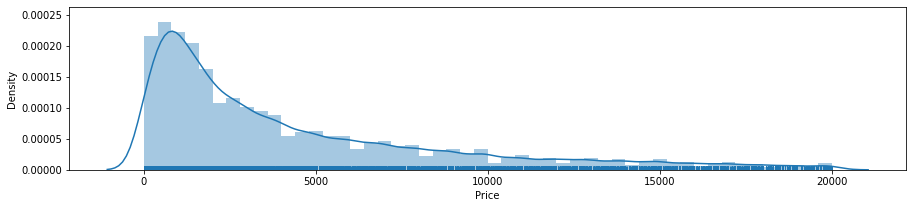

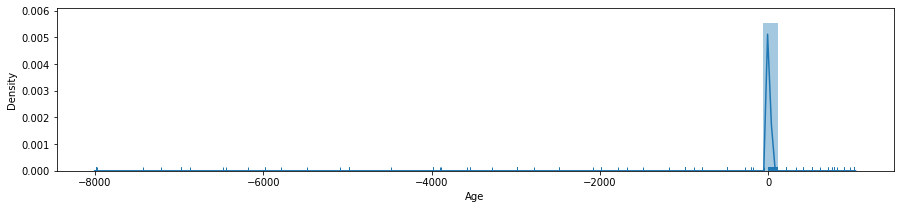

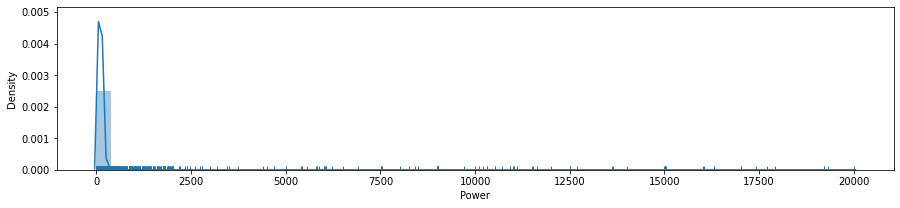

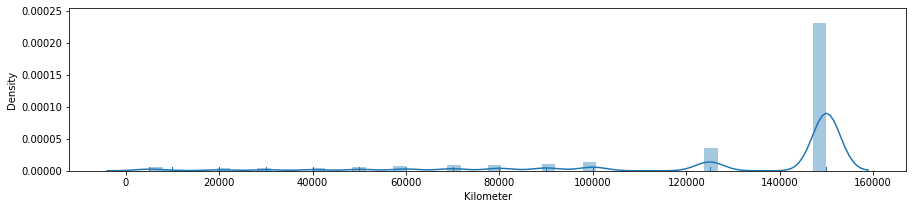

In [17]:
for i in ['Price','Age','Power','Kilometer']:
    plt.figure(figsize=(15,3))
    ax = sns.distplot(data[i], rug=True);
    plt.show()

Подтверждаем выводы выше:

1) По цене- есть объявления с нулевой ценой. Проверим, сколько их

2) Возраст- есть выбросы как с очень большими, так и с очень малыми значениями. Избавимся от отрицательных значений, а также от аномально больших, и просто от чень старых авто (посмотрим, например, сколько есть авто старше 30 лет, если их немного- отсечем все такие данные)

3) Мощность- также много выбросов. Даже у грузового авто мощность обычно не превышает 800л.с., и вряд ли есть авто с мощностью двигателя меньше 20л.с. посчитаем, сколько таких выбросов, если немного- удалим.

4) Пробег- здесь аномалий не видно.

In [18]:
display(data.loc[data['Price'] == 0].shape[0])

10316

10316 объявлений с нулевой ценой. Вероятно, в объявлении цена не была указана. От общего количества это не так много, а ценность для обучения модели у таких данных отсутствует. Удалим их.

Также, посмотрим аноимально низкие цены.

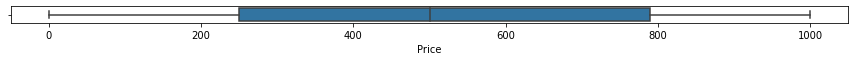

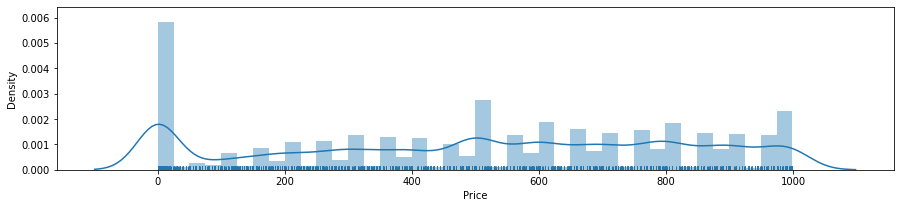

In [19]:
plt.figure(figsize=(15,.3))
sns.boxplot(data.loc[data['Price'] < 1000, 'Price']);
plt.show()
plt.figure(figsize=(15,3))
sns.distplot(data.loc[data['Price'] < 1000, 'Price'], rug=True);
plt.show()

Большой всплеск количества объявлений видим на цене 500 евро. Можно  предположить, что авто с ценой ниже- это либо ультра-бюджетные предложения, либо ошибки или фейковые объявления. Посмотрим, сколько таких авто в сумме.</div>

In [20]:
display(data.loc[data['Price'] < 500].shape[0])

35086

Получается не так много, удалим не только авто с нулевой ценой, но и авто с ценой ниже 500</div>

In [21]:
data = data.loc[data['Price'] >= 500]

Теперь разберемся с годом регистрации авто.

In [22]:
display(data.loc[data['Age'] < 0].shape[0])
display(data.loc[data['Age'] > 30].shape[0])

12745

5100

13470 авто с отрицательным возрастом- получается, указанная для них дата регистрации была более поздней, чем дата создания анкеты, то есть, "автомобиль из будущего". Возраст авто- ключевой показатель, восстановить его не получится, поэтому удалим такие данные.

5485 раритетных авто- тут количество уже относительно небольшое, меньше 2%, ценность таких данных невелика- явный кандидат на удаление.

In [23]:
data = data.query('Age >= 0 and Age <= 30')

Аналогично посмотрим количество выбросов с мощностью двигателя.

In [24]:
display(data.loc[data['Power'] < 20].shape[0])
display(data.loc[data['Power'] > 800].shape[0])

23394

246

278 аномально высоких значений- это немного, такие данные удалим.
30420 низких- очень много, восстановить эти данные мы не сможем, но можем заменить их медианой.

In [25]:
data = data.loc[data['Power'] <= 800]

Медианное значение посчитаем отдельно для разных моделей авто.

In [26]:
data.loc[(data['Power'] < 20), 'Power'] = None
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))

Снова посмотрим диаграммы:

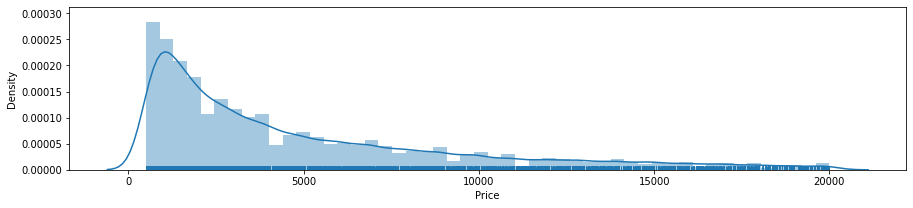

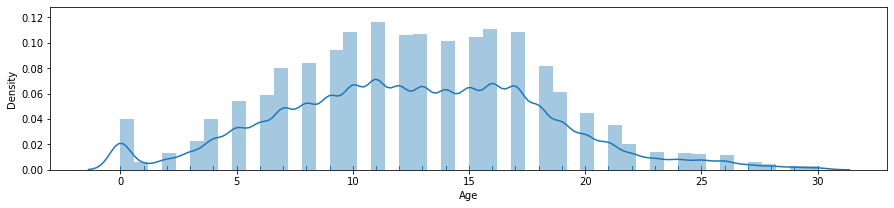

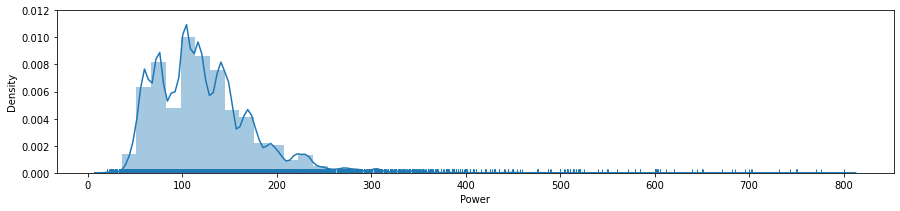

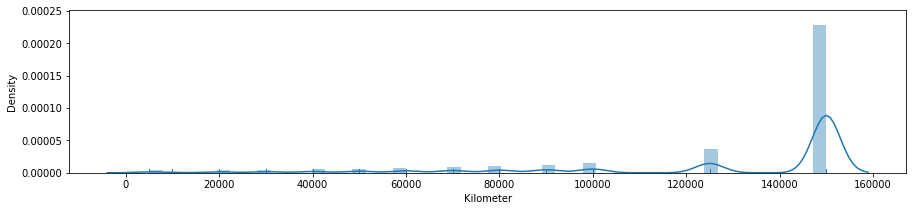

In [27]:
for i in ['Price','Age','Power','Kilometer']:
    plt.figure(figsize=(15,3))
    ax = sns.distplot(data[i], rug=True);
    plt.show()

От аномальных значений избавились.

**Вывод:**

1) Импортировали библиотеки

2) Загрузили данные

3) Избавились от пропусков

4) Избавились от дубликатов

5) Удалили бесполезные для решения задачи признаки

6) Удалили аномалии

Можем приступать к обучению моделей.

## Обучение моделей

Отделим признаки от целевого признака

In [29]:
features = data.drop('Price',axis=1)
target = data['Price']
display(features.head(5))
display(target.head(5))

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Age
1,coupe,manual,190.0,other,125000,gasoline,audi,yes,5
2,suv,auto,163.0,grand,125000,gasoline,jeep,no,12
3,small,manual,75.0,golf,150000,petrol,volkswagen,no,15
4,small,manual,69.0,fabia,90000,gasoline,skoda,no,8
5,sedan,manual,102.0,3er,150000,petrol,bmw,yes,21


1    18300
2     9800
3     1500
4     3600
5      650
Name: Price, dtype: int64

Нам надо сделать много разных выборок, создадим функцию. При необходимости, в нее можно добавлять дополнительные параметры, и получать еще больше различных возможных комбинаций.
Под нашу задачу, сделаем три группы выборок:

1) Для бустинговых моделей- без масштабирования и кодирования, дополнительно для LGBM- c заменой типа данных в столбцах с категориальными признаками. 

2) Для RandomForestRegressor- с кодированием без масштабирования
    
3) Для SGDRegressor-с кодированием и масштабированием. Данный метод требует масштабирования всех признаков, поэтому отмасштабируем все столбцы.

В названиях выборок отразим, для какой они модели.

Для выборок "target" менять каждый раз название не будем- они во всех случаях идентичны

In [31]:
col_scale = ['Power', 'Kilometer', 'Age'] #столбцы для масштабирования
col_oe = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']#столбцы для кодирования

In [32]:
def sc_enc_func(data_f, data_t, sc, enc, col_cat):
    d_f, f_test, d_t, t_test = train_test_split(data_f, data_t, test_size=0.2, random_state=12345)
    f_train, f_valid, t_train, t_valid = train_test_split(d_f, d_t, test_size=0.25, random_state=12345)
    if enc==True:
        encoder = OrdinalEncoder()
        encoder.fit(f_train[col_oe])
        f_train[col_oe] = encoder.transform(f_train[col_oe])
        f_valid[col_oe] = encoder.transform(f_valid[col_oe])
        f_test[col_oe] = encoder.transform(f_test[col_oe])
    if sc==True:
        scaler = StandardScaler()
        scaler.fit(f_train)
        f_train = pd.DataFrame(data = scaler.transform(f_train), columns = f_train.columns)
        f_valid = pd.DataFrame(data = scaler.transform(f_valid), columns = f_train.columns)
        f_test = pd.DataFrame(data = scaler.transform(f_test), columns = f_train.columns)
    if col_cat==True:
        f_train[col_oe] = f_train[col_oe].astype('category')
        f_valid[col_oe] = f_valid[col_oe].astype('category')
        f_test[col_oe] = f_test[col_oe].astype('category')
    return f_train, f_valid, f_test, t_train, t_valid, t_test

In [33]:
CB_train, CB_valid, CB_test, t_train, t_valid, t_test = sc_enc_func(features, target, sc=False, enc=False, col_cat=False)
display(CB_train.head(5))

LGBM_train, LGBM_valid, LGBM_test, t_train, t_valid, t_test = sc_enc_func(features, target, sc=False, enc=False, col_cat=True)
display(LGBM_train.head(5))

RF_train, RF_valid, RF_test, t_train, t_valid, t_test = sc_enc_func(features, target, sc=False, enc=True, col_cat=False)
display(RF_train.head(5))

SGD_train, SGD_valid, SGD_test, t_train, t_valid, t_test = sc_enc_func(features, target, sc=True, enc=True, col_cat=False)
display(SGD_train.head(5))

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Age
43808,coupe,manual,140.0,c_klasse,150000,petrol,mercedes_benz,no,15
30343,sedan,manual,109.0,i_reihe,80000,petrol,hyundai,no,5
87791,small,manual,75.0,one,60000,petrol,mini,no,4
218011,wagon,manual,90.0,doblo,150000,gasoline,fiat,no,9
59729,small,manual,75.0,sandero,20000,petrol,dacia,no,7


,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Age
43808,coupe,manual,140.0,c_klasse,150000,petrol,mercedes_benz,no,15
30343,sedan,manual,109.0,i_reihe,80000,petrol,hyundai,no,5
87791,small,manual,75.0,one,60000,petrol,mini,no,4
218011,wagon,manual,90.0,doblo,150000,gasoline,fiat,no,9
59729,small,manual,75.0,sandero,20000,petrol,dacia,no,7


,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Age
43808,2.0,1.0,140.0,59.0,150000,6.0,20.0,0.0,15
30343,4.0,1.0,109.0,119.0,80000,6.0,12.0,0.0,5
87791,5.0,1.0,75.0,165.0,60000,6.0,21.0,0.0,4
218011,7.0,1.0,90.0,92.0,150000,2.0,9.0,0.0,9
59729,5.0,1.0,75.0,196.0,20000,6.0,6.0,0.0,7


,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Age
0,-1.042091,0.502828,0.329919,-0.722943,0.590486,0.690020,-0.047438,-0.305785,0.420633
1,-0.092493,0.502828,-0.257010,0.132674,-1.312497,0.690020,-0.645311,-0.305785,-1.348914
2,0.382306,0.502828,-0.900740,0.788647,-1.856206,0.690020,0.027296,-0.305785,-1.525869
3,1.331903,0.502828,-0.616742,-0.252353,0.590486,-1.467939,-0.869513,-0.305785,-0.641095
4,0.382306,0.502828,-0.900740,1.230716,-2.943625,0.690020,-1.093715,-0.305785,-0.995005


С подготовкой данных закончили, можем перейти к обучению моделей.

Используем следующие модели:

**RandomForestRegressor**

**LightGBM**

**CatBoostRegressot**

**SGBRegressor**

**Обучение модели RandomForestRegressor**

Попробуем подобрать гипермараметры.

In [35]:
%%time
model_RF = RandomForestRegressor(random_state=1234)
parametrs_grid = {'n_estimators': range(10, 50, 10),'max_depth' : range(10, 50, 5)}
grid_cv = GridSearchCV(model_RF, parametrs_grid, scoring='neg_root_mean_squared_error')
grid_cv.fit(RF_train, t_train)
display(grid_cv.best_params_)

{'max_depth': 20, 'n_estimators': 40}

CPU times: user 17min 37s, sys: 10.3 s, total: 17min 47s
Wall time: 17min 47s


In [36]:
results_RF=pd.DataFrame(grid_cv.cv_results_)
best_score_RF=grid_cv.best_score_
display(results_RF.loc[results_RF['rank_test_score'] == 1])
display(results_RF.loc[results_RF['rank_test_score'] == 1]['mean_fit_time'].values[0])
display(results_RF.loc[results_RF['rank_test_score'] == 1]['mean_score_time'].values[0])
display(best_score_RF)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,10.396114,0.200625,0.388448,0.007505,20,40,"{'max_depth': 20, 'n_estimators': 40}",-1607.037601,-1597.606298,-1627.605993,-1623.083801,-1586.958386,-1608.458416,15.24841,1


10.39611382484436

0.38844804763793944

-1608.45841586049

Теперь сравним с другими моделями.

**Обучение модели LightGBM**

In [38]:
%%time
parametrs_grid = {'max_depth':[2,10],
              'learning_rate': [0.1, 0.8]}
model_LGB = lgb.LGBMRegressor(random_state=1234)
grid_cv = GridSearchCV(estimator = model_LGB,
                               param_grid = parametrs_grid,
                               n_jobs=1,
                               verbose=10,
#                               cv=3,
                               scoring='neg_root_mean_squared_error')

grid_cv.fit(LGBM_train, t_train)
display('best params', grid_cv.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START learning_rate=0.1, max_depth=2..............................
[CV 1/5; 1/4] END ............learning_rate=0.1, max_depth=2; total time=  43.0s
[CV 2/5; 1/4] START learning_rate=0.1, max_depth=2..............................
[CV 2/5; 1/4] END ............learning_rate=0.1, max_depth=2; total time=  43.8s
[CV 3/5; 1/4] START learning_rate=0.1, max_depth=2..............................
[CV 3/5; 1/4] END ............learning_rate=0.1, max_depth=2; total time=  44.4s
[CV 4/5; 1/4] START learning_rate=0.1, max_depth=2..............................
[CV 4/5; 1/4] END ............learning_rate=0.1, max_depth=2; total time=  34.4s
[CV 5/5; 1/4] START learning_rate=0.1, max_depth=2..............................
[CV 5/5; 1/4] END ............learning_rate=0.1, max_depth=2; total time=   2.4s
[CV 1/5; 2/4] START learning_rate=0.1, max_depth=10.............................
[CV 1/5; 2/4] END ...........learning_rate=0.1, m

'best params'

{'learning_rate': 0.1, 'max_depth': 10}

CPU times: user 3min 35s, sys: 1.21 s, total: 3min 36s
Wall time: 3min 38s


In [39]:
results_LGBM=pd.DataFrame(grid_cv.cv_results_)
best_score_LGBM=grid_cv.best_score_
display(results_LGBM.loc[results_LGBM['rank_test_score'] == 1])
display(results_LGBM.loc[results_LGBM['rank_test_score'] == 1]['mean_fit_time'].values[0])
display(results_LGBM.loc[results_LGBM['rank_test_score'] == 1]['mean_score_time'].values[0])
display(best_score_LGBM)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,3.933282,0.174206,0.384657,0.035865,0.1,10,"{'learning_rate': 0.1, 'max_depth': 10}",-1589.686995,-1566.475375,-1609.899976,-1589.446796,-1550.014016,-1581.104632,20.751203,1


3.9332820892333986

0.3846573352813721

-1581.104631603846

Обучим модель с лучшими параметрами:

У этой модели, по сравнению со случайным лесом, и RMSE лучше, и время обучения меньше.

**Обучение модели CatBoostRegressot**

In [41]:
%%time
parametrs_grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 10]}

model_CAT = CatBoostRegressor(loss_function="RMSE",
                              iterations=100, 
                              random_state=1234,
                              cat_features=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'])

grid_cv = GridSearchCV(model_CAT, parametrs_grid, scoring='neg_root_mean_squared_error')

grid_cv.fit(CB_train, t_train)
display('best params', grid_cv.best_params_)

0:	learn: 4443.4416816	total: 98.6ms	remaining: 9.76s
1:	learn: 4363.3567825	total: 131ms	remaining: 6.43s
2:	learn: 4287.6804618	total: 172ms	remaining: 5.56s
3:	learn: 4213.8052079	total: 203ms	remaining: 4.87s
4:	learn: 4144.5702165	total: 234ms	remaining: 4.44s
5:	learn: 4076.2312862	total: 273ms	remaining: 4.28s
6:	learn: 4011.6580994	total: 305ms	remaining: 4.05s
7:	learn: 3944.3932271	total: 337ms	remaining: 3.88s
8:	learn: 3882.9733851	total: 367ms	remaining: 3.71s
9:	learn: 3822.8661946	total: 396ms	remaining: 3.56s
10:	learn: 3765.2829310	total: 424ms	remaining: 3.43s
11:	learn: 3709.3267949	total: 454ms	remaining: 3.33s
12:	learn: 3653.5342209	total: 484ms	remaining: 3.24s
13:	learn: 3601.5494282	total: 515ms	remaining: 3.16s
14:	learn: 3551.8725155	total: 552ms	remaining: 3.13s
15:	learn: 3505.4740881	total: 583ms	remaining: 3.06s
16:	learn: 3459.9793296	total: 616ms	remaining: 3.01s
17:	learn: 3413.1500232	total: 646ms	remaining: 2.94s
18:	learn: 3370.1892268	total: 674ms	

'best params'

{'depth': 10, 'learning_rate': 0.1}

CPU times: user 1min 50s, sys: 1.06 s, total: 1min 51s
Wall time: 2min


In [42]:
results_CB=pd.DataFrame(grid_cv.cv_results_)
best_score_CB=grid_cv.best_score_
display(results_CB.loc[results_CB['rank_test_score'] == 1])
display(results_CB.loc[results_CB['rank_test_score'] == 1]['mean_fit_time'].values[0])
display(results_CB.loc[results_CB['rank_test_score'] == 1]['mean_score_time'].values[0])
display(best_score_CB)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,7.284228,0.20808,0.050238,0.004595,10,0.1,"{'depth': 10, 'learning_rate': 0.1}",-1634.863775,-1611.573361,-1634.367289,-1615.388974,-1580.643709,-1615.367422,19.805223,1


7.284227752685547

0.0502377986907959

-1615.3674217340747

RMSE хуже, чем у LGBM, и скорость обучения хуже, однако скорость предсказаний- лучше.

**Обучение модели SGDRegressor**

In [44]:
%%time

parametrs_grid = {'max_iter': [100, 500, 1000]}
model_SGD = SGDRegressor()

grid_cv = GridSearchCV(model_SGD, param_grid=parametrs_grid, scoring='neg_root_mean_squared_error')

grid_cv.fit(SGD_train, t_train)
display('best params', grid_cv.best_params_)

'best params'

{'max_iter': 1000}

CPU times: user 6.94 s, sys: 1.51 s, total: 8.44 s
Wall time: 8.45 s


In [45]:
results_SGD=pd.DataFrame(grid_cv.cv_results_)
best_score_SGD=grid_cv.best_score_
display(results_SGD.loc[results_SGD['rank_test_score'] == 1])
display(results_SGD.loc[results_SGD['rank_test_score'] == 1]['mean_fit_time'].values[0])
display(results_SGD.loc[results_SGD['rank_test_score'] == 1]['mean_score_time'].values[0])
display(best_score_SGD)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.511523,0.118603,0.003158,0.00009,1000,{'max_iter': 1000},-2834.64164,-2769.685822,-2797.777546,-2800.055485,-2784.521016,-2797.336302,21.578033,1


0.5115225315093994

0.0031577587127685548

-2797.3363017537936

Скорость обучения у модели высокая, но RMSE худший из всех.

Дополнительно, сравним результаты с константной моделью.

In [52]:
%%time
model_dummy = DummyRegressor(strategy='median')
model_dummy.fit(RF_train, t_train)
predict_model_dummy = model_dummy.predict(RF_valid)
rmse_model_dummy = mse(t_valid, predict_model_dummy)**0.5
display('rmse =', rmse_model_dummy)

'rmse ='

4864.304950025063

CPU times: user 7.58 ms, sys: 45 µs, total: 7.62 ms
Wall time: 6.07 ms


Ожидаемо, времени нужно немного, но при этом результат хуждший из всех- все использованные ранее модели эффективнее константной.

Лучшая модель по сочетанию скорости и качества- LGBM. Проверим ее на тестовой выборке.

In [56]:
%%time
model_LGBM = lgb.LGBMRegressor(learning_rate=0.1, 
                              max_depth=10, 
                              random_state=1234)
model_LGBM.fit(LGBM_train, t_train)
predict_model_LGBM = model_LGBM.predict(LGBM_test)
t_rmse_model_LGBM = mse(t_test, predict_model_LGBM)**0.5
display('rmse =', t_rmse_model_LGBM)

'rmse ='

1573.018990302318

CPU times: user 2min 12s, sys: 558 ms, total: 2min 12s
Wall time: 2min 13s


Проверку тестовой выборкой модель прошла.

**Вывод:**

1) Создали выборки, масштабировали признаки

2) Обучили 4 модели

3) Лучший RMSE- у RandomForestRegressor

4) Лучшее время- у SGDRegressor

5) Модели, которые долго обучаются, больше времени тратят и на предсказания.

6) Результаты на тестовой выборке, в целом, повторяют результаты на валидационной

## Анализ моделей

In [62]:
display('Результаты моделей по RMSE:')
display('Модель RF', best_score_RF)
display('Модель CatBoost', best_score_CB)
display('Модель LGBM', best_score_LGBM)
display('Модель SGD', best_score_SGD)

'Результаты моделей по RMSE:'

'Модель RF'

-1608.45841586049

'Модель CatBoost'

-1615.3674217340747

'Модель LGBM'

-1581.104631603846

'Модель SGD'

-2797.3363017537936

In [60]:
display('Результаты моделей по среднему времени обучения:')
display('Модель RF', results_RF.loc[results_RF['rank_test_score'] == 1]['mean_fit_time'].values[0])
display('Модель CatBoost', results_CB.loc[results_CB['rank_test_score'] == 1]['mean_fit_time'].values[0])
display('Модель LGBM', results_LGBM.loc[results_LGBM['rank_test_score'] == 1]['mean_fit_time'].values[0])
display('Модель SGD', results_SGD.loc[results_SGD['rank_test_score'] == 1]['mean_fit_time'].values[0])

'Результаты моделей по времени обучения:'

'Модель RF'

10.39611382484436

'Модель CatBoost'

7.284227752685547

'Модель LGBM'

3.9332820892333986

'Модель SGD'

0.5115225315093994

In [61]:
display('Результаты моделей по среднему времени предсказания:')
display('Модель RF', results_RF.loc[results_RF['rank_test_score'] == 1]['mean_score_time'].values[0])
display('Модель CatBoost', results_CB.loc[results_CB['rank_test_score'] == 1]['mean_score_time'].values[0])
display('Модель LGBM', results_LGBM.loc[results_LGBM['rank_test_score'] == 1]['mean_score_time'].values[0])
display('Модель SGD', results_SGD.loc[results_SGD['rank_test_score'] == 1]['mean_score_time'].values[0])

'Результаты моделей по среднему времени предсказания:'

'Модель RF'

0.38844804763793944

'Модель CatBoost'

0.0502377986907959

'Модель LGBM'

0.3846573352813721

'Модель SGD'

0.0031577587127685548

**Вывод**

1) Самое лучшее сочетание скорости и качества- у модели LGBM

2) Самый лучший RMSE- у LGBM

3) Самая быстрая модель- SGDRegressor, однако ее RMSE сильно ниже конкурентов.

4) Если важна именно скорость предсказаний у уже обученной модели, а RMSE не так критичен- можно также использовать CatBoost

4) Все модели работают лучше константной.

**Итого**

В качестве лучшей модели, можно рекомендовать LGBM. Эта модель имеет лучшее качество предсказаний, и при этом демонстрирует хорошую скорость работы.